Разберемся с библиотекой грубокого обучения fast.ai, ктр представляет собой реализацию коллаборативной фильтрации на Pytorch. Работало только с gpu, без него - очень долго

Использовала официальную [документацию](http://fastai1.fast.ai/collab.html)

In [2]:
import numpy as np
import pandas as pd

from fastai.tabular import *
from fastai.collab import *
from fastai.metrics import auc_roc_score

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/recommendationsv4/sample_submission.csv
/kaggle/input/recommendationsv4/meta_Grocery_and_Gourmet_Food.json
/kaggle/input/recommendationsv4/test.csv
/kaggle/input/recommendationsv4/train.csv


In [3]:
# Загружаем датасеты
train = pd.read_csv('/kaggle/input/recommendationsv4/train.csv')
train = train[['userid','itemid','rating']]
train.columns = ['user_id','item_id','rating']
# Удалим дубликаты из обучающего датасета (без удаления дубликатов скор на kaggle гораздо хуже)
train.drop_duplicates(inplace = True)

test = pd.read_csv('/kaggle/input/recommendationsv4/test.csv')
test = test[['userid', 'itemid']]
test.columns = ['user_id','item_id']

submission = pd.read_csv('/kaggle/input/recommendationsv4/sample_submission.csv')



/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


We'll first turn the userId and movieId columns in category codes, so that we can replace them with their codes when it's time to feed them to an Embedding layer. This step would be even more important if our csv had names of users, or names of items in it. To do it, we simply have to call a CollabDataBunch factory method.

In [4]:
#конвертируем пандасовский датасет с помощью метода CollabDataBunch
data = CollabDataBunch.from_df(
    train,
    seed=32,
    user_name='user_id',
    item_name='item_id',
    rating_name='rating',
    )

# смотрим, что получилось
data.show_batch()

user_id,item_id,target
65921,9040,1.0
84412,21841,1.0
10183,31485,1.0
69275,13497,1.0
93477,34135,1.0


In [ ]:
#второй вариант - сразу определяем обучающий и тестовый датасеты
data = CollabDataBunch.from_df(train, test=test, seed=32)
data.show_batch()

с этим подходом результат получился хуже

пробовала разные параметры для сollab_learner, в итоге самый лучший результат получился вот такой

In [6]:
learn = collab_learner(data, n_factors=50, y_range=(0, 1), wd=1e-2)
#learn = collab_learner(data, n_factors=50, metrics=[auc_roc_score], y_range=(0, 1), wd=1e-1)

Подберем learning rate

Было проведено несколько экспериментов с параметрами для lr_find, сдвигала вернюю и нижнюю границы, меняла параметр num_it

1) параметры по умолчанию

2) learn.lr_find(start_lr=1e-08, end_lr=1000)

3) learn.lr_find(start_lr=1e-04, end_lr=100, num_it = 1000)

4)learn.lr_find(start_lr=1e-08, end_lr=10, num_it = 100000)

5) learn.lr_find(start_lr=1e-04, end_lr=20, num_it = 10000)

6) learn.lr_find(start_lr=1e-20, end_lr=10, num_it = 1000)

7) learn.lr_find(start_lr=1e-15, end_lr=10, num_it = 1000)

в итоге самый лучший результат на kaggle был при использовании параметров по умолчанию

In [7]:
learn.lr_find()

epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


выводим график, чтобы на нем оценить значения LR

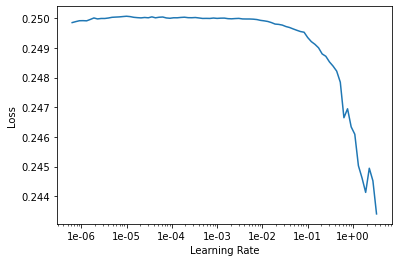

In [8]:
learn.recorder.plot() 

Кривая LR предлагает выбрать что-то около 1e-01  (выбираем значение, которое находится примерно посередине самого крутого нисходящего склона), этот параметр и укажем для модели

Обучаем модель

In [9]:
learn.fit_one_cycle(5, 1e-01)

epoch,train_loss,valid_loss,time
0,0.178771,0.181455,01:40
1,0.201946,0.201443,01:40
2,0.189019,0.179468,01:39
3,0.137563,0.135209,01:42
4,0.084067,0.126932,01:40


Сохраняем модель

In [10]:
learn.save("trained_model", return_path=True)

PosixPath('models/trained_model.pth')

Укажем тестовый датасет (при втором варианте, когда сразу же определяем 2 датасета, этот шаг пропускаем)

In [11]:
data = CollabDataBunch.from_df(train, test=test, seed=32, valid_pct=0.2, user_name='user_id', item_name='item_id', rating_name='rating')
learn = collab_learner(data, n_factors=50, y_range=(0, 1), wd=1e-2)
#learn = collab_learner(data, n_factors=50, y_range=(0, 1))
#learn = collab_learner(data, n_factors=50, metrics=[auc_roc_score], y_range=(0.0, 1.0), wd=1e-1)

Загрузим ранее сохраненную модель

In [12]:
learn_loaded = learn.load(Path('trained_model'))

Получаем предсказания рейтинга

In [13]:
preds, y = learn_loaded.get_preds(DatasetType.Test)

In [14]:
submission['rating']= preds

проверим минимальное и максимальное значение рейтинга, вдруг придется нормировать

In [15]:
submission.rating.min(), submission.rating.max()

(1.2719679034489673e-05, 0.9999991655349731)

In [16]:
submission.to_csv('submission_fastai.csv', index=False)

В результате всех манипуляций максимальный результат на kaggle составил 0.73863, что близко к бэйзлайну